# Data Analysis Project: Eligibility Prediction for Loan
* Author: Marco Andronaco
* Subject: Statistical Laboratory
* Teacher: Alessandro Ortis - University of Catania

## Step 0: libraries, functions and constants
First of all, let's install the single required library for this analysis.

The `require()` function returns `FALSE` if the requested library is not installed, so we can install it only when necessary.

In [1]:
if (!require("corrplot")) install.packages("corrplot")
library("corrplot")

Caricamento del pacchetto richiesto: corrplot

corrplot 0.92 loaded



To get a consistent feel for my analysis, I decided to use the [Open Color 1.9.1](https://yeun.github.io/open-color/) palette.

In [2]:
col.gray = "#adb5bd"
col.red = "#ff6b6b"
col.pink = "#f06595"
col.grape = "#cc5de8"
col.violet = "#845ef7"
col.indigo = "#5c7cfa"
col.blue = "#339af0"
col.cyan = "#22b8cf"
col.teal = "#20c997"
col.green = "#51cf66"
col.lime = "#94d82d"
col.yellow = "#fcc419"
col.orange = "#ff922b"

In [3]:
pie_chart = function(x, col=1:length(x), legend=names(x), main="Pie Chart"){
    piepercent = paste(round(100*x/sum(x), 2), '%', sep="")
    
    pie(x, labels=piepercent, col=col, main=main)
    legend("topright", legend, fill=col)
}

## Step 1: loading and cleaning our data
The dataset comes from [Kaggle](https://www.kaggle.com/datasets/meirnizri/covid19-dataset). Here's the provided description:

>Coronavirus disease (COVID-19) is an infectious disease caused by a newly discovered coronavirus. Most people infected with COVID-19 virus will experience mild to moderate respiratory illness and recover without requiring special treatment. Older people, and those with underlying medical problems like cardiovascular disease, diabetes, chronic respiratory disease, and cancer are more likely to develop serious illness.
During the entire course of the pandemic, one of the main problems that healthcare providers have faced is the shortage of medical resources and a proper plan to efficiently distribute them. In these tough times, being able to predict what kind of resource an individual might require at the time of being tested positive or even before that will be of immense help to the authorities as they would be able to procure and arrange for the resources necessary to save the life of that patient.

>The main goal of this project is to build a machine learning model that, given a Covid-19 patient's current symptom, status, and medical history, will predict whether the patient is in high risk or not.

>The dataset was provided by the [Mexican government](https://datos.gob.mx/busca/dataset/informacion-referente-a-casos-covid-19-en-mexico). This dataset contains an enormous number of anonymized patient-related information including pre-conditions. The raw dataset consists of 21 unique features and 1,048,576 unique patients. In the Boolean features, 1 means "yes" and 2 means "no". values as 97 and 99 are missing data.

| Variable | Description |
|:---|:-------------|
| sex | female or male |
| age | age of the patient |
| classification | covid test findings |
| patient type | hospitalized or not hospitalized |
| pneumonia | whether the patient already have air sacs inflammation or not |
| pregnancy | whether the patient is pregnant or not |
| diabetes | whether the patient has diabetes or not |
| copd | Indicates whether the patient has Chronic obstructive pulmonary disease or not |
| asthma | whether the patient has asthma or not |
| inmsupr | whether the patient is immunosuppressed or not |
| hypertension | whether the patient has hypertension or not |
| cardiovascular | whether the patient has heart or blood vessels related disease |
| renal chronic | whether the patient has chronic renal disease or not |
| other disease | whether the patient has other disease or not |
| obesity | whether the patient is obese or not |
| tobacco | whether the patient is a tobacco user |
| usmr | Indicates whether the patient treated medical units of the first, second or third level |
| medical unit | type of institution of the National Health System that provided the care |
| intubed | whether the patient was connected to the ventilator |
| icu | Indicates whether the patient had been admitted to an Intensive Care Unit |
| death | indicates whether the patient died or recovered |

Finally, the following's stated regarding the `classification` variable:
> Values 1-3 mean that the patient was diagnosed with covid in different degrees. 4 or higher means that the patient is not a carrier of covid or that the test is inconclusive.

Let's start by loading the actual data. Watch out, the `COPD` column will be hidden whenever we show our data.

In [4]:
df = read.csv("Covid Data.csv")

row.n1 = nrow(df)
print(paste(row.n1, "rows loaded."))
names(df)
head(df)

[1] "1048575 rows loaded."


[1] "USMER"                "MEDICAL_UNIT"         "SEX"                 
 [4] "PATIENT_TYPE"         "DATE_DIED"            "INTUBED"             
 [7] "PNEUMONIA"            "AGE"                  "PREGNANT"            
[10] "DIABETES"             "COPD"                 "ASTHMA"              
[13] "INMSUPR"              "HIPERTENSION"         "OTHER_DISEASE"       
[16] "CARDIOVASCULAR"       "OBESITY"              "RENAL_CHRONIC"       
[19] "TOBACCO"              "CLASIFFICATION_FINAL" "ICU"

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DATE_DIED,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,⋯,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
,<int>,<int>,<int>,<int>,<chr>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,2,1,1,1,03/05/2020,97,1,65,2,2,⋯,2,2,1,2,2,2,2,2,3,97
2,2,1,2,1,03/06/2020,97,1,72,97,2,⋯,2,2,1,2,2,1,1,2,5,97
3,2,1,2,2,09/06/2020,1,2,55,97,1,⋯,2,2,2,2,2,2,2,2,3,2
4,2,1,1,1,12/06/2020,97,2,53,2,2,⋯,2,2,2,2,2,2,2,2,7,97
5,2,1,2,1,21/06/2020,97,2,68,97,1,⋯,2,2,1,2,2,2,2,2,3,97
6,2,1,1,2,9999-99-99,2,1,40,2,2,⋯,2,2,2,2,2,2,2,2,3,2


First of all, we want to focus our analysis on the patients that have tested positive for COVID, so we can just remove all rows which have values $\geq 5$ on the `CLASIFFICATION_FINAL` column.

In [5]:
df = df[df$CLASIFFICATION_FINAL < 4,] # 4 or higher means that the patient is not a carrier of covid or that the test is inconclusive.

Also, the short introduction told us that numbers like 97, 98 and 99 are supposed to be missing values.

While this holds true for some columns, like `TOBACCO`:

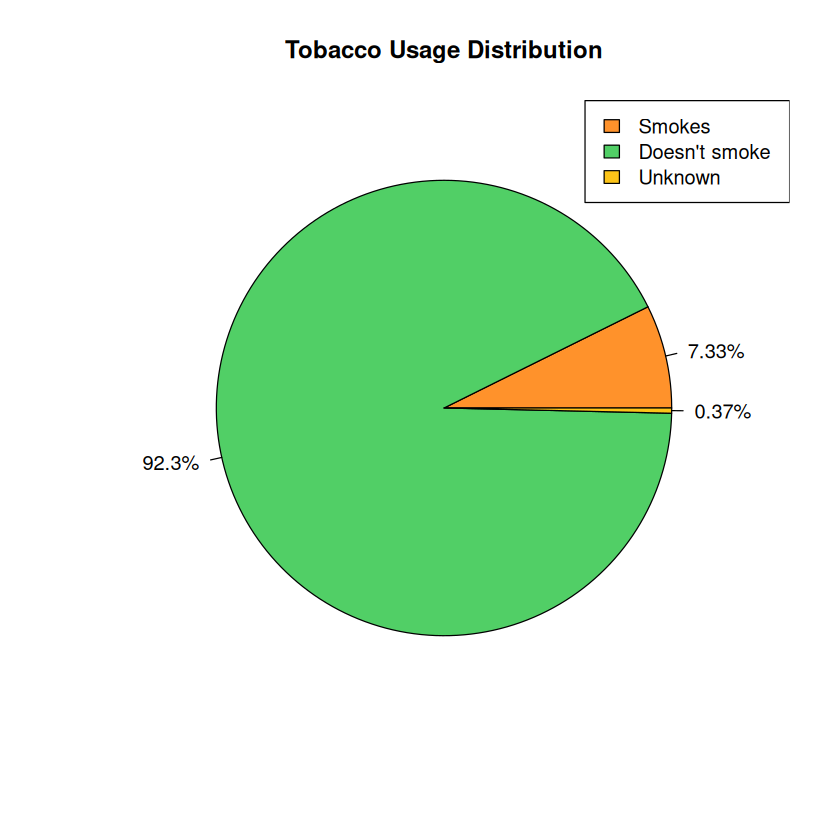

In [6]:
pie_chart(table(df$TOBACCO),
          col=c(col.orange, col.green, col.yellow),
          legend=c("Smokes", "Doesn't smoke", "Unknown"),
          main="Tobacco Usage Distribution"
         )

For other columns, like `PREGNANT`, the meaning of the numbers is not so clear.

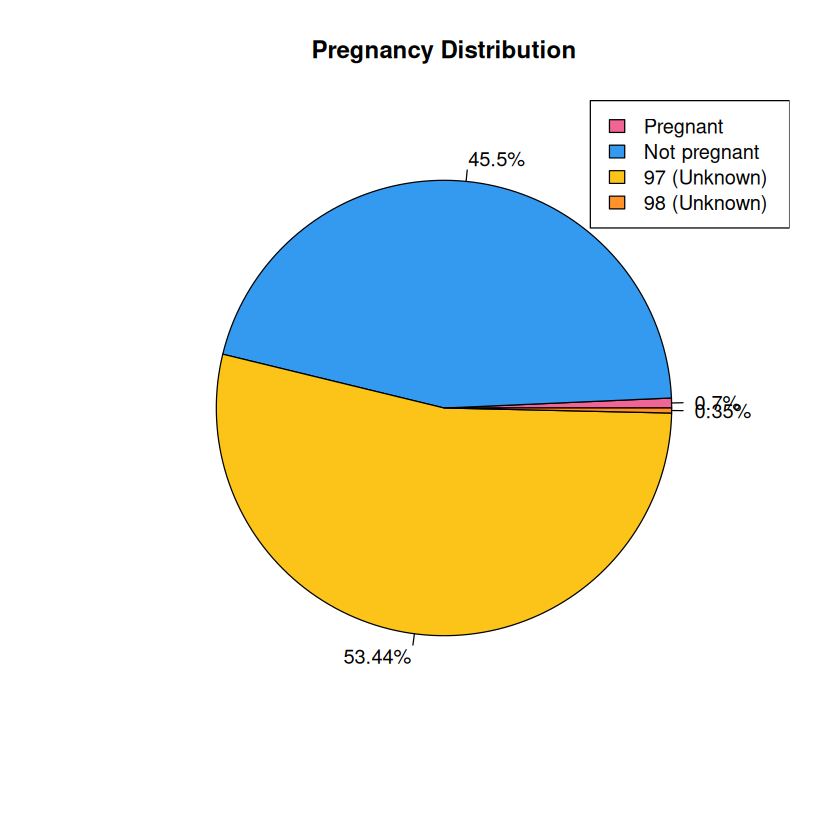

In [7]:
pie_chart(table(df$PREGNANT),
          col=c(col.pink, col.blue, col.yellow, col.orange),
          legend=c("Pregnant", "Not pregnant", "97 (Unknown)", "98 (Unknown)"),
          main="Pregnancy Distribution"
         )

The amount of _97_ values is bigger than the number of non-pregnant patients. This could probably mean that _97_ was used as an indicator for values that do not make sense logically (for example, men cannot be pregnant).

We can check the amounts and see that they coincide:

In [8]:
print(paste("Number of male patients: ", table(df$SEX)[2]))
print(paste("Number of 97 values: ", table(df$PREGNANT)[3]))

[1] "Number of male patients:  209489"
[1] "Number of 97 values:  209489"


Let's start by removing rows which have missing values on each variable:

In [9]:
df = df[df$PNEUMONIA != 99,]
df = df[df$INTUBED != 99,]
df = df[df$ICU != 99,]
df = df[df$DIABETES != 98,]
df = df[df$COPD != 98,]
df = df[df$ASTHMA != 98,]
df = df[df$INMSUPR != 98,]
df = df[df$HIPERTENSION != 98,]
df = df[df$OTHER_DISEASE != 98,]
df = df[df$CARDIOVASCULAR != 98,]
df = df[df$OBESITY != 98,]
df = df[df$RENAL_CHRONIC != 98,]
df = df[df$TOBACCO != 98,]
df = df[df$PREGNANT != 98,]

row.n2 = nrow(df)
print(paste("Removed", row.n1 - row.n2, "rows."))
print(paste(row.n2, "rows left in dataframe."))

[1] "Removed 662475 rows."
[1] "386100 rows left in dataframe."


Now, replace the _97_ values in columns where it makes sense.

* Men cannot be pregnant;
* Non-hospitalized patients cannot be intubed;
* Non-hospitalized patients cannot be in intensive care.

We will also replace the _2_ values with _0_, because it better signifies the absence of a given trait.

In [10]:
# fix unknown values
df$PREGNANT[df$PREGNANT == 97] <- 0
df$INTUBED[df$INTUBED == 97] <- 0
df$ICU[df$ICU == 97] <- 0

# replace negative cases
df$USMER[df$USMER == 2] <- 0
df$SEX[df$SEX == 2] <- 0
df$INTUBED[df$INTUBED == 2] <- 0
df$PNEUMONIA[df$PNEUMONIA == 2] <- 0
df$PREGNANT[df$PREGNANT == 2] <- 0
df$DIABETES[df$DIABETES == 2] <- 0
df$COPD[df$COPD == 2] <- 0
df$ASTHMA[df$ASTHMA == 2] <- 0
df$INMSUPR[df$INMSUPR == 2] <- 0
df$HIPERTENSION[df$HIPERTENSION == 2] <- 0
df$OTHER_DISEASE[df$OTHER_DISEASE == 2] <- 0
df$CARDIOVASCULAR[df$CARDIOVASCULAR == 2] <- 0
df$OBESITY[df$OBESITY == 2] <- 0
df$TOBACCO[df$TOBACCO == 2] <- 0
df$ICU[df$ICU == 2] <- 0

df$PATIENT_TYPE = df$PATIENT_TYPE - 1
# for this last variable, we need 1 to become 0
# and 2 to become 1, so we can just subtract 1.

df$DATE_DIED <- ifelse(df$DATE_DIED == "9999-99-99", 0, 1)
# For our analysis, we don't care about the exact date
# of the death of our patients. We can make it so we
# have 1 if the patient died, and 0 otherwise.

Finally, we can craft our target column `AT_RISK`, which will summarize if the patient can be considered at risk or not.
In particular, the column has value 1 if the patient has either:
* Been hospitalized,
* Been in Intensive Care Unit,
* Been intubed,
* Died.

We can also remove all the columns with useless or redundant information.

In [11]:
df$AT_RISK = df$DATE_DIED + df$INTUBED + df$ICU + df$PATIENT_TYPE
df$AT_RISK <- ifelse(df$AT_RISK > 0, 1, 0)

df = within(df, rm('CLASIFFICATION_FINAL', 'INTUBED', 'ICU', 'DATE_DIED', 'PATIENT_TYPE', 'MEDICAL_UNIT', 'USMER'))
head(df)

,SEX,PNEUMONIA,AGE,PREGNANT,DIABETES,COPD,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,AT_RISK
,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>
1,1,1,65,0,0,0,0,0,1,0,0,0,2,0,1
3,0,0,55,0,1,0,0,0,0,0,0,0,2,0,1
5,0,0,68,0,1,0,0,0,1,0,0,0,2,0,1
6,1,1,40,0,0,0,0,0,0,0,0,0,2,0,1
7,1,0,64,0,0,0,0,0,0,0,0,0,2,0,0
8,1,1,64,0,1,0,0,1,1,0,0,0,1,0,0


## Step 2: Data visualization
Now that we have a clean dataset, we can plot some of our data.

>Please be wary that from now on all visualizations are valid under the assumption that they have already been tested positive for COVID.

First of all, the target column, where we expect to see some class imbalance.

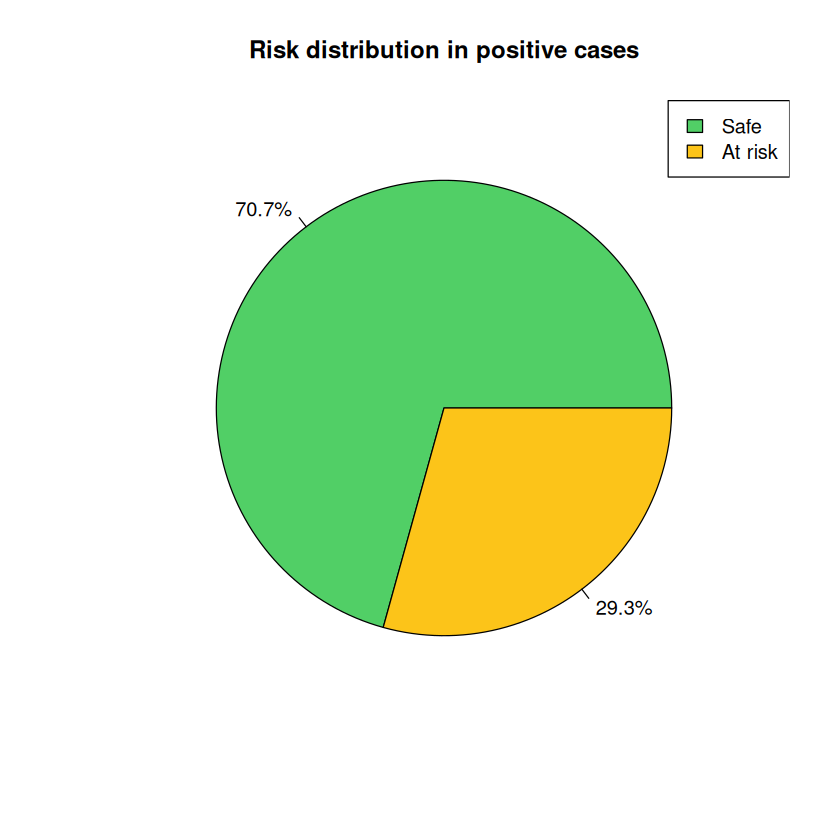

In [12]:
p = table(df$AT_RISK)
pie_chart(p, col=c(col.green, col.yellow), legend=c("Safe", "At risk"), main="Risk distribution in positive cases")

The `AGE` column follows a _positively-skewed_ normal distribution:

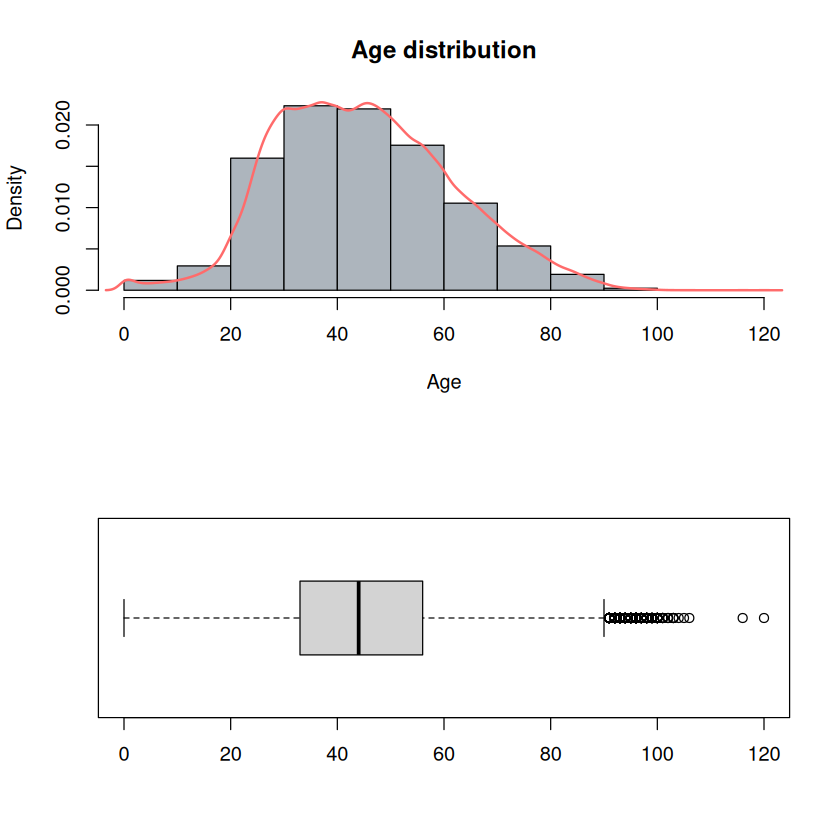

In [13]:
par(mfrow=c(2,1))
hist(df$AGE, freq=FALSE, col=col.gray, main="Age distribution", xlab="Age", breaks=10)
lines(density(df$AGE), col=col.red, lwd=2)
boxplot(df$AGE, horizontal=TRUE)

Let's check out more interesting pie graphs:

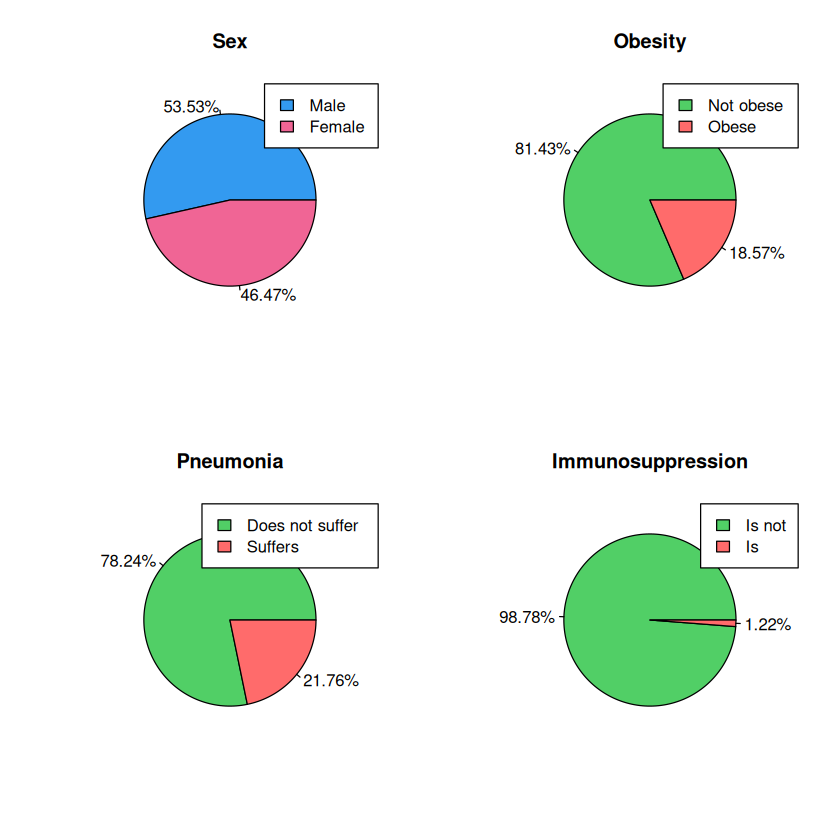

In [14]:
par(mfrow=c(2,2))

pie_chart(table(df$SEX),
          col=c(col.blue, col.pink),
          legend=c("Male", "Female"),
          main="Sex"
         )
pie_chart(table(df$OBESITY),
          col=c(col.green, col.red),
          legend=c("Not obese", "Obese"),
          main="Obesity"
         )
pie_chart(table(df$PNEUMONIA),
          col=c(col.green, col.red),
          legend=c("Does not suffer", "Suffers"),
          main="Pneumonia"
         )
pie_chart(table(df$INMSUPR),
          col=c(col.green, col.red),
          legend=c("Is not", "Is"),
          main="Immunosuppression"
         )

Let's now compute the covariance matrix. It is a symmetric matrix that contains the variance of each feature and the cross-features covariances:

$$
\Sigma =
\begin{bmatrix}
Var(x) & Cov(x, y) \\
Cov(y, x) & Var(y)
\end{bmatrix}
$$

When the two features are positively correlated, the covariance is greater than zero, otherwise, it has a negative value. Furthermore, if there is no evidence of a correlation between them, the covariance is equal to zero.

We'll use the `round()` function to get results up to the third decimal unit.

In [15]:
cov_matrix = cov(df)
round(cov_matrix, 3)

,SEX,PNEUMONIA,AGE,PREGNANT,DIABETES,COPD,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,AT_RISK
SEX,0.249,-0.019,-0.348,0.004,-0.001,0.000,0.004,0.001,0.001,0.002,-0.001,0.004,0.001,-0.013,-0.025
PNEUMONIA,-0.019,0.170,2.330,-0.001,0.034,0.004,-0.001,0.002,0.033,0.003,0.004,0.013,-0.005,0.002,0.129
AGE,-0.348,2.330,270.189,-0.116,1.984,0.311,-0.065,0.066,2.588,0.124,0.322,0.374,-0.215,0.001,3.202
PREGNANT,0.004,-0.001,-0.116,0.007,-0.001,0.000,0.000,0.000,-0.001,0.000,0.000,-0.001,0.000,0.000,0.000
DIABETES,-0.001,0.034,1.984,-0.001,0.133,0.004,0.000,0.002,0.054,0.002,0.005,0.015,-0.008,0.001,0.046
COPD,0.000,0.004,0.311,0.000,0.004,0.015,0.001,0.001,0.005,0.001,0.002,0.002,-0.001,0.002,0.006
ASTHMA,0.004,-0.001,-0.065,0.000,0.000,0.001,0.026,0.000,0.001,0.000,0.000,0.003,0.000,0.000,-0.001
INMSUPR,0.001,0.002,0.066,0.000,0.002,0.001,0.000,0.012,0.002,0.002,0.001,0.001,-0.002,0.000,0.003
HIPERTENSION,0.001,0.033,2.588,-0.001,0.054,0.005,0.001,0.002,0.157,0.003,0.009,0.023,-0.010,0.001,0.047
OTHER_DISEASE,0.002,0.003,0.124,0.000,0.002,0.001,0.000,0.002,0.003,0.025,0.001,0.001,-0.001,0.001,0.005


We can scan the `AT_RISK` row horizontally and find out that the highest values lie in the intersections with the `AGE` and `PNEUMONIA` columns.
Also, the `AGE` column has the highest value for variance, since it's the only numerical variable.

Let's now use the `corrplot` function as a way to visualize the correlation matrix.

We can use the `method` parameter of the `cor()` function to define which correlation coefficient (or covariance) should be computed. Some choices are:
* Pearson's product-moment correlation coefficient ($r$),
* Kendall's rank correlation coefficient ($\tau$),
* Spearman's rank correlation coefficient ($\rho$).

We can also use the `order` parameter of the `corrplot()` function to indicate how to reorder the correlation matrix, in particular:
* `AOE` for the angular order of the eigenvectors,
* `FPC` for the first principal component order,
* `hclust` for hierarchical clustering order,
* `alphabet` for alphabetical order.

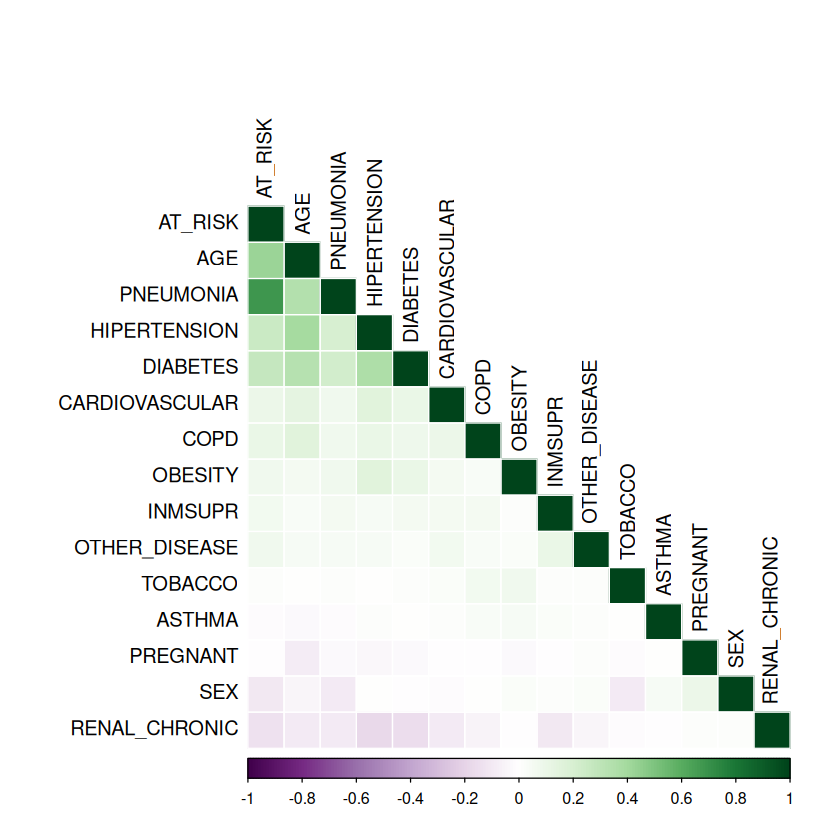

In [16]:
cor_matrix = cor(df,
    method="pearson" # {"pearson", "kendall", "spearman"}
)

corrplot(cor_matrix,
    type="lower",
    addgrid.col = 'white',
    #addCoef.col = col.green, # coefficient text color
    #number.cex=0.70, # coefficient text size
    method="color", # make only colored squares
    order="FPC", # {"AOE", "FPC", "hclust", "alphabet"}
    tl.col="black", # text-label color
    col=COL2("PRGn") # color scheme
)

With this visualization, it's easy to distinguish some _positive correlations_ by looking at the first column:
* between `AT_RISK` and `PNEUMONIA`;
* between `AT_RISK` and `AGE`;
* in general, between `AGE` and various diseases.

## Step 3: Unsupervised Learning
### PCA
We can use the `prcomp` function to perform principal component analysis. However, it quickly becomes very slow for datasets with a big number of rows.

To solve this, we can use the `sample()` function to take a random subset of 10.000 elements.

In [17]:
set.seed(2)
ss = sample(1:nrow(df), 10000) # take 10.000 random rows
df.subset = df[ss,] # select only those rows from our dataframe

Now we can use the `scale()` function to scale our subset, then `prcomp` to make our PCA.

In [18]:
df.scaled = scale(df.subset) # scale our subset
pca = prcomp(df.scaled)

names(pca)

[1] "sdev"     "rotation" "center"   "scale"    "x"

We can quickly visualize the first two principal components by creating a biplot with this function:

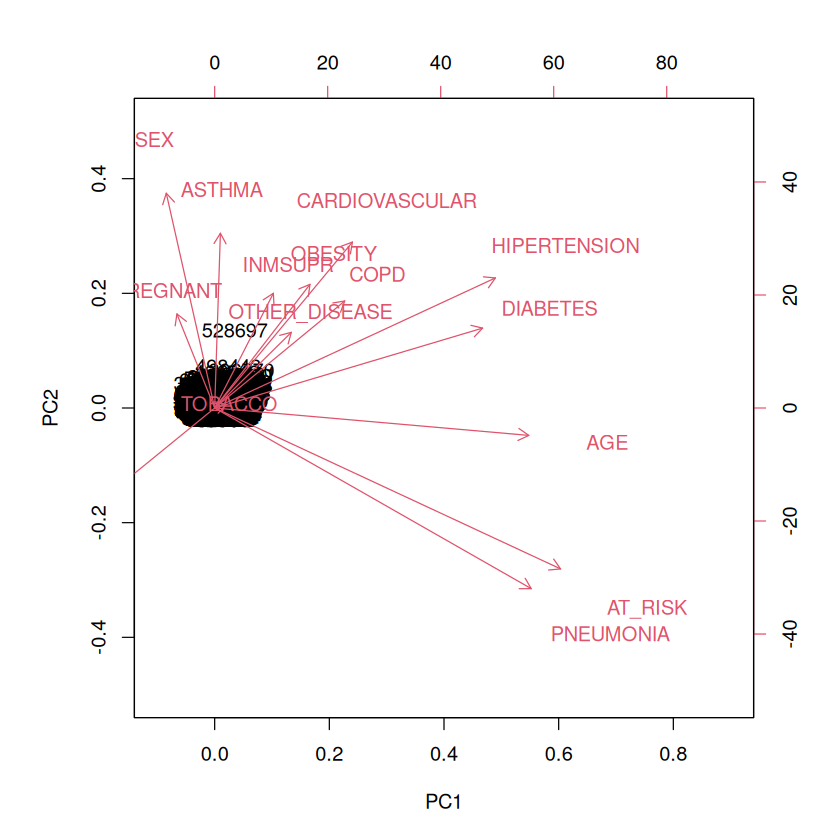

In [19]:
range = 1
x.start = -0.1
y.start = -0.5

biplot(pca,
       expand=20,
       xlim=c(x.start, (x.start + range)),
       ylim=c(y.start, (y.start + range)))

Keep in mind, I used the `expand` parameter to zoom in the pictures, so there are some samples that are not visible in this plot.

However, this graph makes it clear how the first PC is almost completely governed by `AGE`'s variability.

* As we move towards increasing `AGE`, we also see an increase for `AT_RISK`;
* The same goes for `PNEUMONIA`, in an even greater measure.

We can check out the `rotation` matrix to see that PC1 has big values for `AGE`, `PNEUMONIA` and `AT_RISK`.

These are the eigenvectors 

In [20]:
pca$rotation

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15
SEX,-0.065475537,0.426351367,-0.37769519,0.26515956,0.232970839,0.045771961,0.25537192,-0.07484843,0.25368812,0.28213088,-0.43166984,-0.37556134,0.02969184,-0.022522082,-0.0325132403
PNEUMONIA,0.428334895,-0.358556764,-0.18793277,-0.10532340,0.245056054,0.083046629,-0.10778804,-0.03384113,-0.02082018,-0.02861701,-0.25594473,-0.04860265,0.09659994,-0.226054575,0.6574855652
AGE,0.425033270,-0.054395110,0.01434897,0.15953241,-0.006506965,-0.038902290,0.18497774,-0.14918872,0.10210436,0.03191891,0.20655457,-0.12131873,-0.43583162,0.676816393,0.1258764020
PREGNANT,-0.051110559,0.186686556,-0.37278634,0.03756730,0.555519688,-0.253599105,-0.24087832,0.47312294,-0.06022703,-0.12269556,0.33567339,0.14614751,-0.06511354,0.099560404,0.0224344573
DIABETES,0.362534735,0.158596021,0.03918978,0.23971147,-0.153345180,0.063341488,-0.02211305,0.09281797,0.09558067,0.16748692,0.33957599,-0.02232894,0.76252238,0.114085598,0.0182626960
COPD,0.175990849,0.212420213,0.20531228,-0.16668667,0.210932029,-0.485640115,0.23008251,-0.29620791,0.36513186,-0.09699256,-0.13002564,0.50895217,0.09812794,-0.068034791,-0.0050919606
ASTHMA,0.007739916,0.346889205,0.03590655,-0.06935040,0.249092737,0.327722314,-0.51349661,-0.60904742,-0.15962579,0.11776153,0.14026481,0.08747732,-0.04383208,0.027160831,0.0104377177
INMSUPR,0.079436163,0.227740047,-0.28081368,-0.51229741,-0.266071477,0.211081752,-0.07838967,0.03604258,0.47471202,-0.44255296,0.13082010,-0.19797585,-0.01356665,-0.001766035,0.0050730204
HIPERTENSION,0.379829904,0.258177587,0.10057429,0.27295676,-0.161291637,0.001906995,0.02437790,0.10800334,0.04105158,0.07336555,0.27859000,-0.01799374,-0.42081750,-0.635599936,-0.0098396727
OTHER_DISEASE,0.103721651,0.150202420,-0.24975286,-0.50869242,-0.030664995,0.179582884,0.48219338,0.05196526,-0.39084899,0.38990562,0.14580216,0.22507650,-0.01452712,-0.012542088,0.0077473695


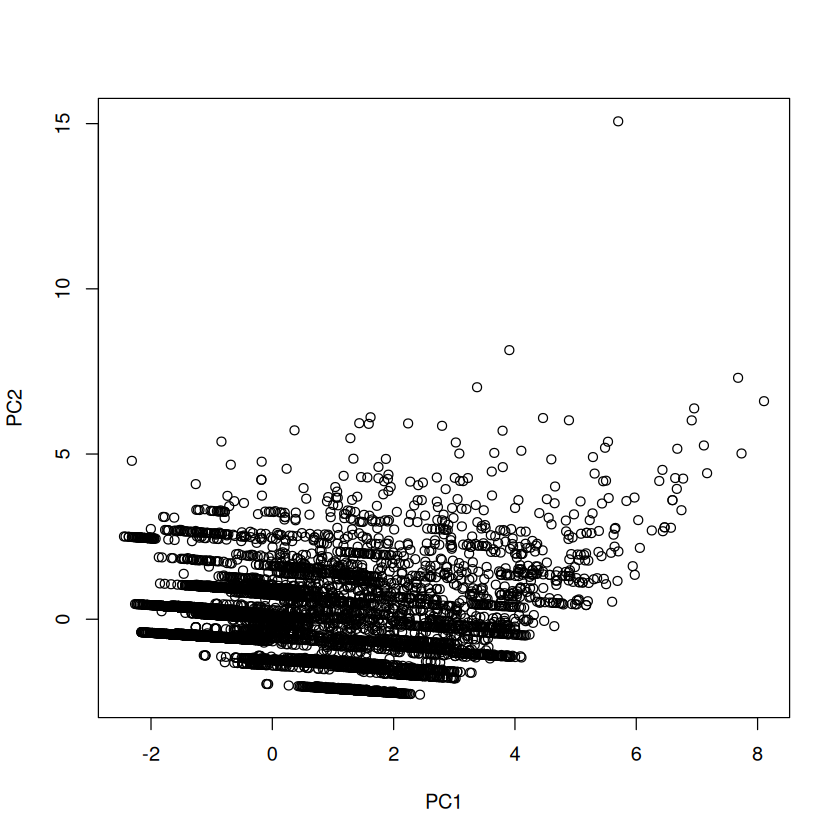

In [21]:
pca_scores = data.frame(pca$x[,1:2])
plot(pca_scores)

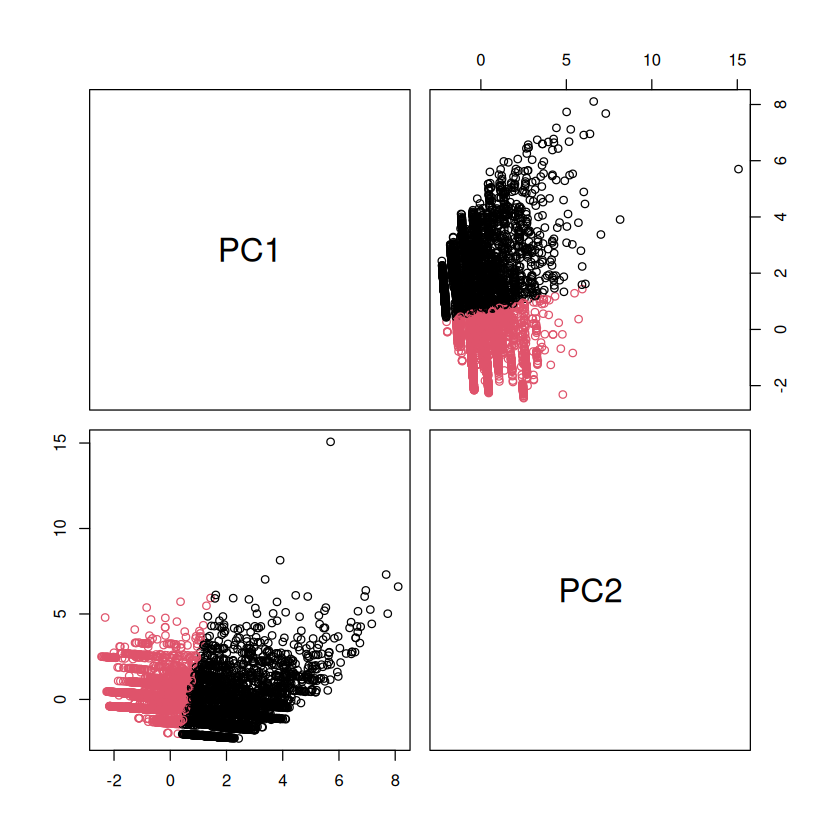

In [22]:
data = pca$x[,1:2]
# K means is not suitable for factor variables because
# it is based on the distance and discrete values
# do not return meaningful values. 

# K-Means Clustering with k clusters
k = 2
fit <- kmeans(data, k)
pairs(data, col=c(1:k)[fit$cluster])

## Step 4: Supervised Learning
### Logistic Regression

In [23]:
set.seed(2)
train.percent = 0.8

s = sample(c(TRUE, FALSE), nrow(df), replace=TRUE, prob=c(train.percent, (1 - train.percent)))

train = df[s,]
test = df[!s,]

l = length(train)

X_train = train[,1:(length(train)-1)]
y_train = train$AT_RISK

X_test = test[,1:(length(test)-1)]
y_test = test$AT_RISK

In [24]:
simple_logistic_model = glm(formula=y_train~., data=X_train, family=binomial)

saveRDS(simple_logistic_model, file="model.rda")
summary(simple_logistic_model)


Call:
glm(formula = y_train ~ ., family = binomial, data = X_train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.5690  -0.4856  -0.3336   0.2712   3.1002  

Coefficients:
                 Estimate Std. Error z value Pr(>|z|)    
(Intercept)    -1.9615652  0.0793765 -24.712  < 2e-16 ***
SEX            -0.4799111  0.0120138 -39.947  < 2e-16 ***
PNEUMONIA       3.7351540  0.0146266 255.368  < 2e-16 ***
AGE             0.0478965  0.0004166 114.969  < 2e-16 ***
PREGNANT        1.6461797  0.0594691  27.681  < 2e-16 ***
DIABETES        0.5910326  0.0154400  38.279  < 2e-16 ***
COPD            0.4011124  0.0430199   9.324  < 2e-16 ***
ASTHMA         -0.1473584  0.0378735  -3.891 9.99e-05 ***
INMSUPR         0.6642928  0.0482274  13.774  < 2e-16 ***
HIPERTENSION    0.2566937  0.0150923  17.008  < 2e-16 ***
OTHER_DISEASE   0.8016977  0.0328350  24.416  < 2e-16 ***
CARDIOVASCULAR  0.0979876  0.0367507   2.666  0.00767 ** 
OBESITY         0.1459514  0.0146886   9.936  < 

In [25]:
# The type="response" option tells R to output probabilities of the
# form P(Y = 1|X), as opposed to other information such as the logit.
predictions = predict(simple_logistic_model, X_test, type="response")

In [26]:
threshold = 0.2
predicted_classes <- ifelse(predictions > threshold, 1, 0)

head(data.frame(actual=y_test, probability=predictions, result=predicted_classes))

,actual,probability,result
,<dbl>,<dbl>,<dbl>
7,0,0.16579916,0
8,0,0.99143335,1
10,1,0.02978072,0
18,0,0.21763954,1
19,0,0.16593005,0
25,0,0.14915961,0


In [27]:
(confusion.matrix = table(Actual=y_test, Predicted=predicted_classes))

accuracy = mean(predicted_classes == y_test)
recall = (confusion.matrix[2,2] / (confusion.matrix[2,2] + confusion.matrix[2,1]))
print(paste("Accuracy:", accuracy))
print(paste("Recall:", recall))

      Predicted
Actual     0     1
     0 46170  8799
     1  3945 18701

[1] "Accuracy: 0.835804934613155"
[1] "Recall: 0.8257970502517"


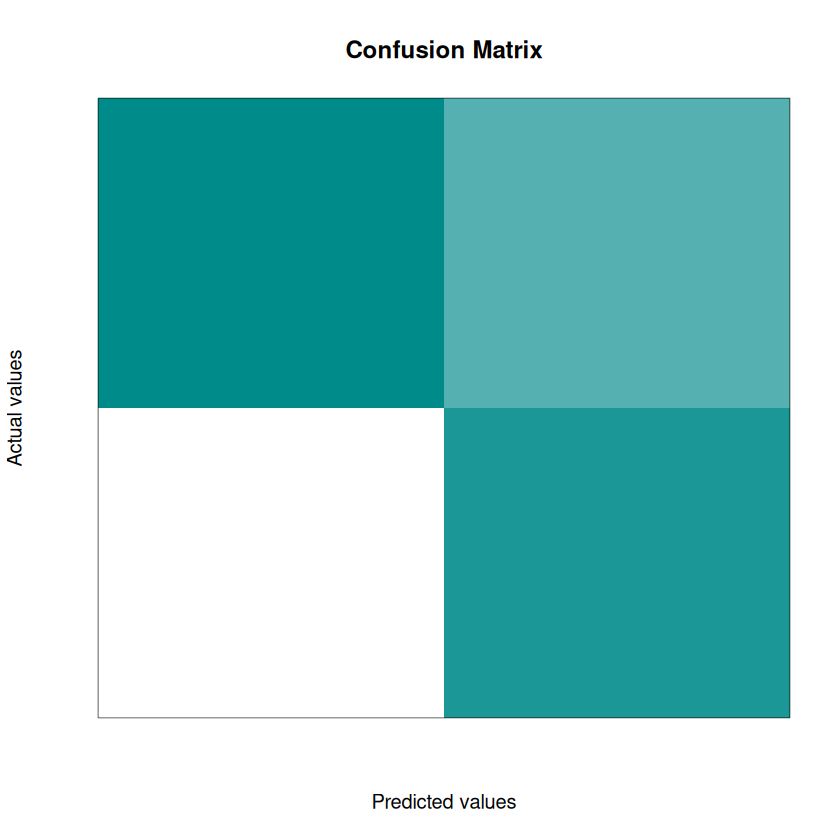

In [28]:
palette = colorRampPalette(c("darkcyan", "white"))(10) # 10: number of levels on the color ramp

image(t(confusion.matrix), # transpose the matrix, otherwise it's flipped
      col=palette,
      xaxt="n", yaxt="n", # hide axes
      xlab="Predicted values", ylab="Actual values",
      main="Confusion Matrix",
     )

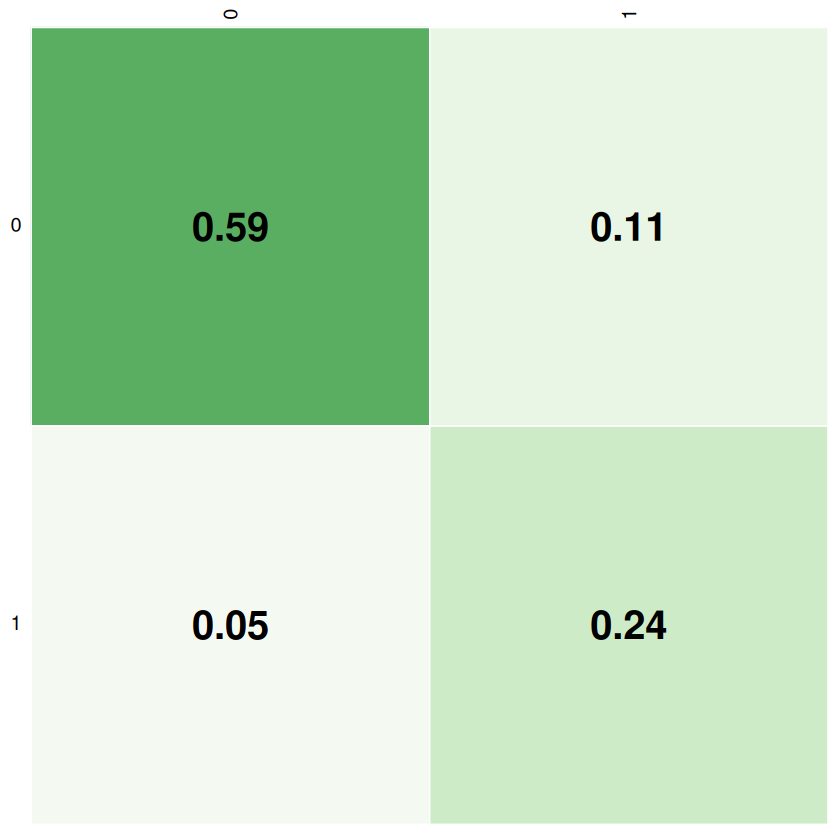

In [30]:
corrplot(confusion.matrix / length(y_test),
    addgrid.col = 'white',
    addCoef.col = 'black', # coefficient text color
    number.cex = 2, # coefficient text size
    method = "color", # make only colored squares
    tl.col = "black", # text-label color
    col = COL2("PRGn"), # color scheme
    cl.pos = "n", # remove color legend
    tl.srt = 90
)